# Import Packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
print(tf.__version__)


2.5.0


# Utility Packages

In [4]:
def plotSeries(time, series, format="-", start = 0, end = None):    
    plt.figure(figsize=(20, 8))
    if type(series) is tuple:
        for _ in series:
            plt.plot(time[start:end], _[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)    
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0 ):
    return slope* time

In [6]:
def seasonalPattern(seasonTime):
    return np.where(seasonTime < 0.4, np.cos(seasonTime * 2 * np.pi), 1/np.exp(3*seasonTime))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    seasonTime = ((time + phase) % period) / period
    return amplitude * seasonalPattern(seasonTime)

In [8]:
def noise(time, noiseLevel = 1, seed=99):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noiseLevel

In [9]:
def windowDataset(series, windowSize, batchSize, shuffleBuffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)  # Generate a TF Dataset from the series values
    dataset = dataset.window(windowSize + 1, shift=1, drop_remainder = True) # Window the data but only take those with the specified size
    dataset = dataset.flat_map(lambda window: window.batch(windowSize + 1)) # Flatten the windows by putting its elements in a single batch
    dataset = dataset.shuffle(shuffleBuffer).map(lambda window: (window[:-1], window[-1])) # Create tuples with features and labels, and shuffle
    dataset = dataset.batch(batchSize).prefetch(1) # Create batches of windows
    return dataset

# The Series

In [10]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
amplitude = 40
noiseLevel = 5
slope = 0.05

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude = amplitude)
series+= noise(time, noiseLevel)

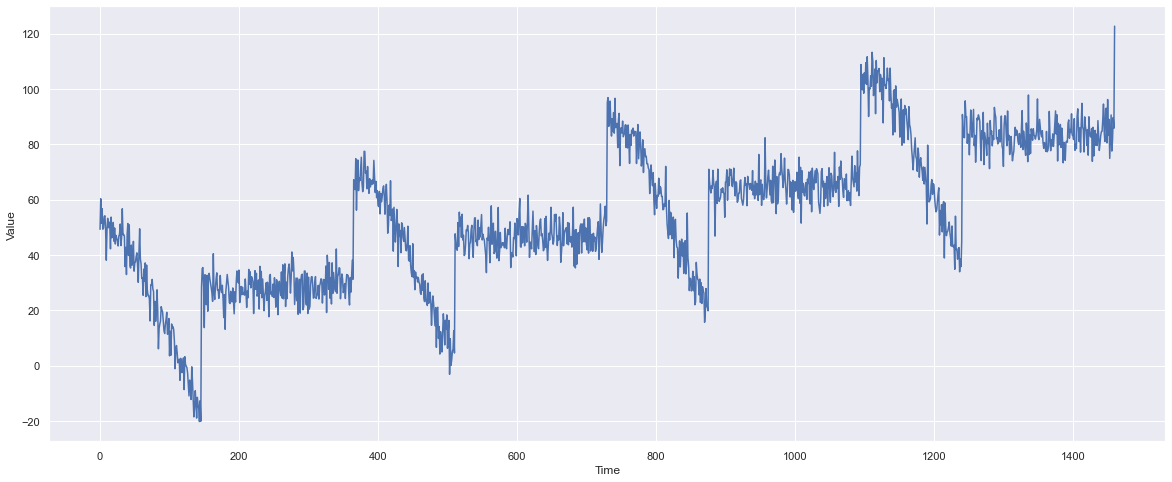

In [12]:
plotSeries(time, series)
plt.show()

## The Split

In [13]:
splitTime = 1000
timeTrain = time[:splitTime]
xTrain = series[:splitTime]
timeValid = time[splitTime:]
xValid = series[splitTime:]

# Training Field

In [14]:
windowSize = 20
batchSize = 32
shuffleBufferSize = 1000

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [16]:
trainSet = windowDataset(xTrain, windowSize, batchSize, shuffleBufferSize)

## Model - Single LSTM Layer

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [18]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

## Model Summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                8704      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

Epoch 1/500


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/bidirectional/forward_lstm/PartitionedCall]] [Op:__inference_train_function_5499]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plotSeries(timeValid, (xValid, results))

In [ ]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)

## Model - Double Layer 

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [ ]:
model.summary()

### Tune Learning Rate

In [ ]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [ ]:
history = model.fit(trainSet, epochs=500, callbacks=[lrSchedule, earlyStop])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [ ]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

In [ ]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plotSeries(timeValid, (xValid, results))

In [ ]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)

## Triple Layer Model

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [ ]:
model.summary()

### Tuning Learning Rate

In [ ]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [ ]:
history = model.fit(trainSet, epochs=500, callbacks=[lrSchedule, earlyStop])

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [ ]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

In [ ]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plotSeries(timeValid, (xValid, results))

In [ ]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)